In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import dask.array as da
import pyproj
import sys
from joblib import Parallel, delayed
from tqdm import tqdm

pd.set_option("display.max_rows", 200)
import pdb

from pycontrails import Flight, Fleet, MetDataset
from pycontrails.core import models
from pycontrails.datalib.ecmwf import ERA5
from pycontrails.physics import geo, thermo, units, constants

# from pycontrails.models.ps_model import PSFlight
# from pycontrails.models.emissions import Emissions
from pycontrails.ext.flight_gen import FlightGen
from pycontrails.models.boxmodel.boxm_ac import Boxm

# from pycontrails.models.dry_advection import DryAdvection
from pycontrails.core.met_var import (
    AirTemperature,
    RelativeHumidity,
    SpecificHumidity,
    EastwardWind,
    NorthwardWind,
    VerticalVelocity,
)

In [2]:
# meteorological parameters
met_params = {
    "air_temperature": 235.0,  # K
    "specific_humidity": 0.003,  # 1
    "relative_humidity": 0.5,  # 1
    "eastward_wind": 0.0,  # m/s
    "northward_wind": 0.0,  # m/s
    "lagrangian_tendency_of_air_pressure": 0.0,  # m/s
}

In [3]:
# flight trajectory parameters
fl_params = {
    "t0_fl": pd.to_datetime("2022-01-20 14:00:00"),  # flight start time
    "rt_fl": pd.Timedelta(minutes=60),  # flight run time
    "ts_fl": pd.Timedelta(minutes=2),  # flight time step
    "ac_type": "A320",  # aircraft type
    "fl0_speed": 100.0,  # m/s
    "fl0_heading": 0.0,  # deg
    "fl0_coords0": (47.55, -32.5, 12500),  # lat, lon, alt [deg, deg, m]
    "sep_dist": (5000, 2000, 0),  # dx, dy, dz [m]
    "n_ac": 1,  # number of aircraft
}

In [4]:
 # plume dispersion parameters
plume_params = {
    "dt_integration": pd.Timedelta(minutes=5),  # integration time step
    "max_age": pd.Timedelta(hours=2),  # maximum age of the plume
    "depth": 50.0,  # initial plume depth, [m]
    "width": 50.0,  # initial plume width, [m]
    "shear": 0.01,  # wind shear [1/s]
}

In [5]:
# chemistry sim parameters
chem_params = {
    "t0_chem": pd.to_datetime("2022-01-20 12:00:00"),  # chemistry start time
    "rt_chem": pd.Timedelta(hours=6),  # chemistry runtime
    "ts_chem": pd.Timedelta(seconds=20),  # chemistry time step
    "lat_bounds": (47.0, 48.0),  # lat bounds [deg]
    "lon_bounds": (-33.0, -32.0),  # lon bounds [deg]
    "alt_bounds": (12000, 13000),  # alt bounds [m]
    "hres_pl": 0.02,  # horizontal resolution of the plume, [deg]
    "hres_chem": 0.1,  # horizontal resolution [deg]
    "vres_chem": 500,  # vertical resolution [m]
}

In [6]:
lats_pl = np.arange(
    chem_params["lat_bounds"][0], chem_params["lat_bounds"][1] + chem_params["hres_pl"], chem_params["hres_pl"]
)

lons_pl = np.arange(
    chem_params["lon_bounds"][0], chem_params["lon_bounds"][1] + chem_params["hres_pl"], chem_params["hres_pl"]
)

In [7]:
lats = np.arange(
    chem_params["lat_bounds"][0], chem_params["lat_bounds"][1] + chem_params["hres_chem"], chem_params["hres_chem"]
)

lons = np.arange(
    chem_params["lon_bounds"][0], chem_params["lon_bounds"][1] + chem_params["hres_chem"], chem_params["hres_chem"]
)

alts = np.arange(
    chem_params["alt_bounds"][0], chem_params["alt_bounds"][1] + chem_params["vres_chem"], chem_params["vres_chem"]
)

times = pd.date_range(
    start=chem_params["t0_chem"],
    end=chem_params["t0_chem"] + chem_params["rt_chem"],
    freq=chem_params["ts_chem"],
)

In [8]:
# generate artifical met dataset (boxm currently only supports zero-wind scenarios)
data_vars = {
    param: (
        ["longitude", "latitude", "level", "time"],
        da.full(
            (len(lons), len(lats), len(alts), len(times)),
            value,
            chunks=(len(lons), len(lats), len(alts), 100),
        ),
    )
    for param, value in met_params.items()
}

met = xr.Dataset(
    data_vars,
    coords={"longitude": lons, "latitude": lats, "level": units.m_to_pl(alts), "time": times},
)

met = MetDataset(met)

met

MetDataset with data:

<xarray.Dataset> Size: 22MB
Dimensions:                              (longitude: 12, latitude: 12,
                                          level: 3, time: 1081)
Coordinates:
  * longitude                            (longitude) float64 96B -33.0 ... -31.9
  * latitude                             (latitude) float64 96B 47.0 ... 48.1
  * level                                (level) float64 24B 165.1 178.6 193.3
  * time                                 (time) datetime64[ns] 9kB 2022-01-20...
    air_pressure                         (level) float64 24B 1.651e+04 ... 1....
    altitude                             (level) float64 24B 1.3e+04 ... 1.2e+04
Data variables:
    air_temperature                      (longitude, latitude, level, time) float64 4MB dask.array<chunksize=(12, 12, 3, 100), meta=np.ndarray>
    specific_humidity                    (longitude, latitude, level, time) float64 4MB dask.array<chunksize=(12, 12, 3, 100), meta=np.ndarray>
    relative_humidity                    (longitude, latitude, level, time) float64 4MB dask.array<chunksize=(12, 12, 3, 100), meta=np.ndarray>
    eastward_wind                        (longitude, latitude, level, time) float64 4MB dask.array<chunksize=(12, 12, 3, 100), meta=np.ndarray>
    northward_wind                       (longitude, latitude, level, time) float64 4MB dask.array<chunksize=(12, 12, 3, 100), meta=np.ndarray>
    lagrangian_tendency_of_air_pressure  (longitude, latitude, level, time) float64 4MB dask.array<chunksize=(12, 12, 3, 100), meta=np.ndarray>

In [9]:
# instantiate FlightGen object
fl_gen = FlightGen(met, fl_params, plume_params, chem_params)

In [10]:
fl = fl_gen.traj_gen()

fl

[Flight [4 keys x 5 length, 3 attributes]
 	Keys: longitude, latitude, altitude, time
 	Attributes:
 	time                [2022-01-20 14:00:00, 2022-01-20 14:08:00]
 	longitude           [-32.5, -32.5]
 	latitude            [47.5, 47.932]
 	altitude            [12500.0, 12500.0]
 	flight_id           0
 	aircraft_type       A320
 	crs                 EPSG:4326]

In [11]:
# estimate fuel burn and emissions using ps_model and emissions model
fl = fl_gen.calc_fb_emissions()

/home/ktait98/pycontrails_kt/pycontrails/ext/flight_gen.py:128: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  flights[i].dataframe[column] = flights[i].dataframe[column].fillna(method='ffill')


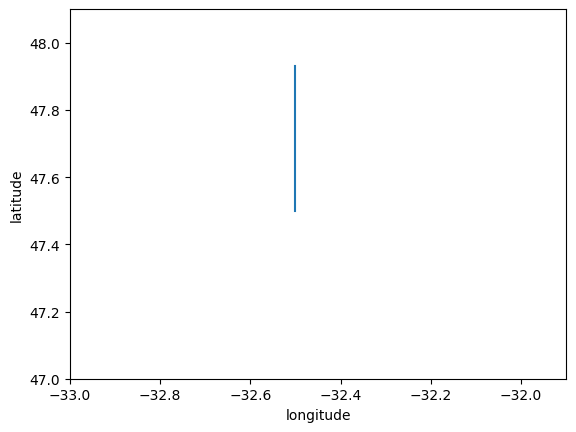

In [12]:
# visualise the fleet
ax = plt.axes()
ax.set_xlim([lons[0], lons[-1]])
ax.set_ylim([lats[0], lats[-1]])
for i in fl:
    i.plot(ax=ax)

In [13]:
# simulate plume dispersion/advection using dry advection model
fl_df, pl_df = fl_gen.sim_plumes()

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 30)

fl_df

/home/ktait98/pycontrails_kt/pycontrails/ext/flight_gen.py:182: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  flights[i][column] = flights[i][column].fillna(method='ffill')


,longitude,latitude,altitude,time,air_temperature,specific_humidity,true_airspeed,flight_id,aircraft_mass,engine_efficiency,fuel_flow,fuel_burn,thrust,rocd,fuel_flow_per_engine,...,nvpm_number,CO2,H2O,SO2,nvPM,NO,NO2,CO,HCHO,CH3CHO,C2H4,C3H6,C2H2,BENZENE,waypoint
0,-32.5,47.500000,12500.0,2022-01-20 14:00:00,235.0,0.003,100.009404,0.0,59450.531326,0.097151,0.803968,96.47615,96602.446771,0.0,0.401984,...,1.051590e+17,0.000001,3.955150e-07,2.701078e-10,2.305563e-11,3.728776e-09,1.962514e-10,1.975123e-10,2.312339e-12,7.707795e-13,2.890423e-12,7.707795e-13,7.707795e-13,3.853898e-13,0
1,-32.5,47.607925,12500.0,2022-01-20 14:02:00,235.0,0.003,100.009404,0.0,59354.055176,0.097151,0.803968,96.47615,96297.785745,0.0,0.401984,...,1.051590e+17,0.000001,3.955150e-07,2.701078e-10,2.305563e-11,3.728776e-09,1.962514e-10,1.975123e-10,2.312339e-12,7.707795e-13,2.890423e-12,7.707795e-13,7.707795e-13,3.853898e-13,1
2,-32.5,47.715850,12500.0,2022-01-20 14:04:00,235.0,0.003,100.009404,0.0,59257.579027,0.097151,0.803968,96.47615,95993.709187,0.0,0.401984,...,1.051590e+17,0.000001,3.955150e-07,2.701078e-10,2.305563e-11,3.728776e-09,1.962514e-10,1.975123e-10,2.312339e-12,7.707795e-13,2.890423e-12,7.707795e-13,7.707795e-13,3.853898e-13,2
3,-32.5,47.823775,12500.0,2022-01-20 14:06:00,235.0,0.003,100.009404,0.0,59161.102877,0.097151,0.803968,96.47615,95690.215904,0.0,0.401984,...,1.051590e+17,0.000001,3.955150e-07,2.701078e-10,2.305563e-11,3.728776e-09,1.962514e-10,1.975123e-10,2.312339e-12,7.707795e-13,2.890423e-12,7.707795e-13,7.707795e-13,3.853898e-13,3
4,-32.5,47.931699,12500.0,2022-01-20 14:08:00,235.0,0.003,100.009404,0.0,59064.626728,0.097151,0.803968,96.47615,95690.215904,0.0,0.401984,...,1.051590e+17,0.000001,3.955150e-07,2.701078e-10,2.305563e-11,3.728776e-09,1.962514e-10,1.975123e-10,2.312339e-12,7.707795e-13,2.890423e-12,7.707795e-13,7.707795e-13,3.853898e-13,4


In [14]:
fl_gen.anim_fl(fl_df, pl_df)

In [15]:
# convert plume dataframe to EMI geospatial xarray dataset
emi = fl_gen.plume_to_grid(lats_pl, lons_pl, alts, times)

Processing time:  2022-01-20 14:05:00


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Processing time:  2022-01-20 14:10:00


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Processing time:  2022-01-20 14:15:00


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Processing time:  2022-01-20 14:20:00


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Processing time:  2022-01-20 14:25:00


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Processing time:  2022-01-20 14:30:00


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Processing time:  2022-01-20 14:35:00


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Processing time:  2022-01-20 14:40:00


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Processing time:  2022-01-20 14:45:00


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Processing time:  2022-01-20 14:50:00


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Processing time:  2022-01-20 14:55:00


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Processing time:  2022-01-20 15:00:00


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Processing time:  2022-01-20 15:05:00


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Processing time:  2022-01-20 15:10:00


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Processing time:  2022-01-20 15:15:00


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Processing time:  2022-01-20 15:20:00


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Processing time:  2022-01-20 15:25:00


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Processing time:  2022-01-20 15:30:00


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Processing time:  2022-01-20 15:35:00


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Processing time:  2022-01-20 15:40:00


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Processing time:  2022-01-20 15:45:00


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Processing time:  2022-01-20 15:50:00


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Processing time:  2022-01-20 15:55:00


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Processing time:  2022-01-20 16:00:00


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Processing time:  2022-01-20 16:05:00


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [16]:
# init boxm simulation and generate chemistry dataset
boxm = Boxm(met=met, params=chem_params)

/home/ktait98/miniconda3/envs/contrails/lib/python3.12/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [17]:
# run boxm simulation
chem = boxm.eval(emi)

/home/ktait98/pycontrails_kt/pycontrails/models/boxmodel/boxm_ac.py:174: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  self.boxm_ds["J"] = (["time", "level", "longitude", "latitude", "photol_params"], da.zeros((self.boxm_ds.dims["time"], self.boxm_ds.dims["level"], self.boxm_ds.dims["longitude"], self.boxm_ds.dims["latitude"], 5)))
/home/ktait98/pycontrails_kt/pycontrails/models/boxmodel/boxm_ac.py:176: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  self.boxm_ds["DJ"] = (["time", "level", "longitude", "latitude", "photol_coeffs"], da.zeros((self.boxm_ds.dims["time"], self.boxm_ds.dims["leve

MultiIndex([(165.10085173011288,               -33.0,               47.0),
            (165.10085173011288,               -33.0,               47.1),
            (165.10085173011288,               -33.0,               47.2),
            (165.10085173011288,               -33.0, 47.300000000000004),
            (165.10085173011288,               -33.0, 47.400000000000006),
            (165.10085173011288,               -33.0,  47.50000000000001),
            (165.10085173011288,               -33.0,  47.60000000000001),
            (165.10085173011288,               -33.0,  47.70000000000001),
            (165.10085173011288,               -33.0,  47.80000000000001),
            (165.10085173011288,               -33.0,  47.90000000000001),
            ...
            (193.30062328740988, -31.899999999999984,               47.2),
            (193.30062328740988, -31.899999999999984, 47.300000000000004),
            (193.30062328740988, -31.899999999999984, 47.400000000000006),
         

/tmp/ipykernel_145025/1770926626.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


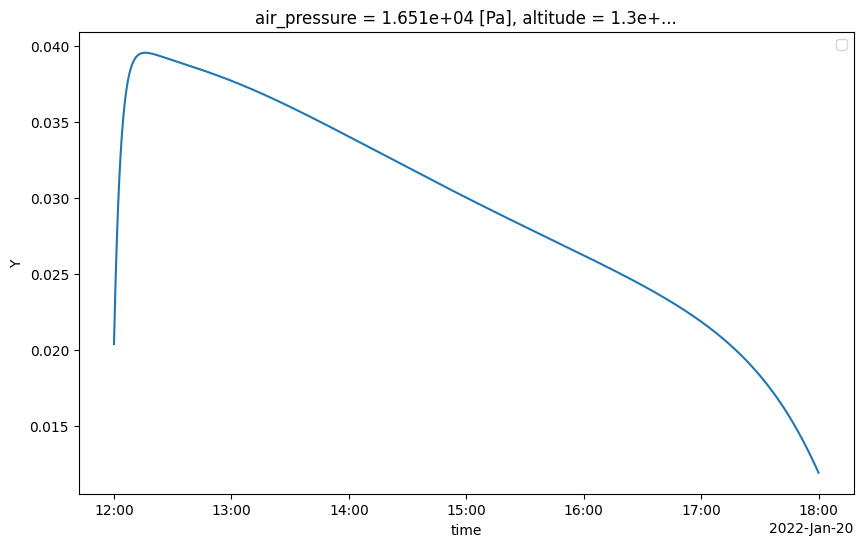

In [18]:
plt.figure(figsize=(10, 6))  # Optional: Adjust figure size

boxm.boxm_ds["Y"].sel(species="NO", cell=14).plot()
#boxm.boxm_ds["Y_orig"].sel(species="NO").plot()
plt.legend()
plt.show()

<xarray.DataArray 'emi' (time: 1081, longitude: 12, latitude: 12)> Size: 1MB
array([[[ 0.,  0.,  0., ...,  0.,  0., nan],
        [ 0.,  0.,  0., ...,  0.,  0., nan],
        [ 0.,  0.,  0., ...,  0.,  0., nan],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0., nan],
        [ 0.,  0.,  0., ...,  0.,  0., nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[ 0.,  0.,  0., ...,  0.,  0., nan],
        [ 0.,  0.,  0., ...,  0.,  0., nan],
        [ 0.,  0.,  0., ...,  0.,  0., nan],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0., nan],
        [ 0.,  0.,  0., ...,  0.,  0., nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[ 0.,  0.,  0., ...,  0.,  0., nan],
        [ 0.,  0.,  0., ...,  0.,  0., nan],
        [ 0.,  0.,  0., ...,  0.,  0., nan],
        ...,
...
        ...,
        [ 0.,  0.,  0., ...,  0.,  0., nan],
        [ 0.,  0.,  0., ...,  0.,  0., nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[ 0.,  0.,  0., ...,  0.,  0., nan],
      

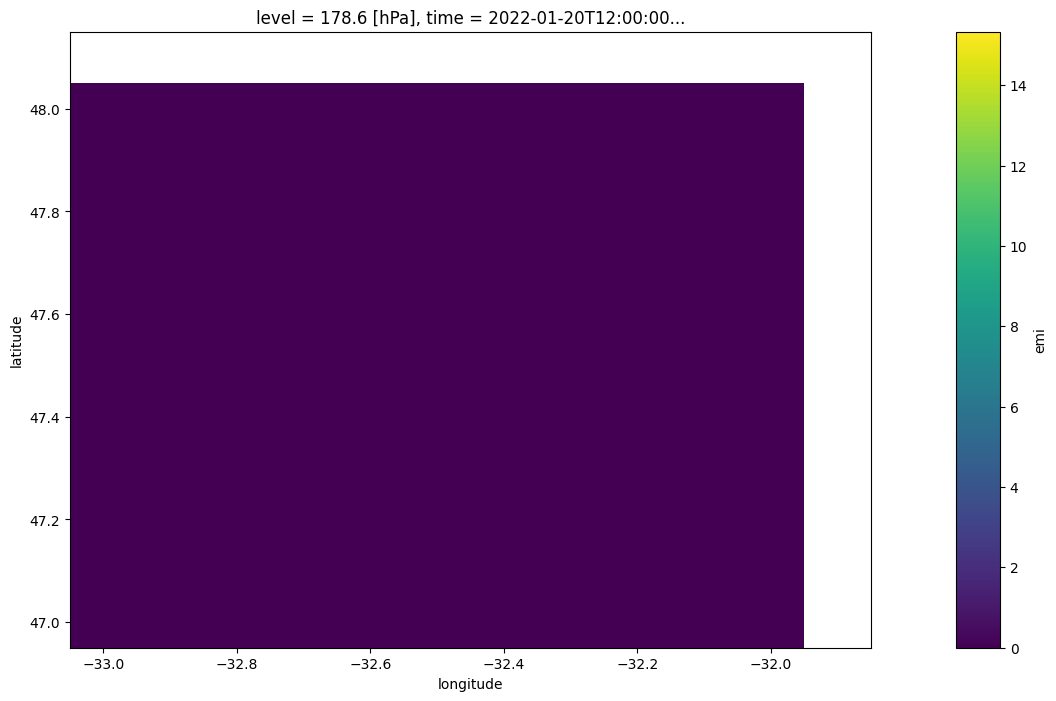

In [19]:
boxm.anim_chem("emi", "NO", 178.6)